# WMTS

pyeodh uses OWSLib for it's WMTS component (see [OWSLib documentation](https://owslib.readthedocs.io/en/latest/)). `pyeodh.Client.get_wmts()` method returns an initialized OWSLib `WebMapTileService` object, which you can use to further interact with the API.

If you're not familiar with how WMTS works, see this [OGC training material](https://opengeospatial.github.io/e-learning/wmts/text/index.html). In short, the main entrypoint to using the service is understanding it's capabilities and getting to know it's metadata ([GetCapabilites operation](https://opengeospatial.github.io/e-learning/wmts/text/main.html)). The next step is using the metadata to fetch tiles using the GetTile operation.

Initialize `pyeodh` and the WMTS:

In [1]:
import pyeodh
import folium

client = pyeodh.Client()
wmts = client.get_wmts()


Retrieve metadata about the service

In [3]:
print(wmts.identification.title) # not all attributes have to be populated in the API, in this case the service title is not set.
print(wmts.identification.type)
print(wmts.identification.version)

None
OGC WMTS
1.0.0


Retrieve content metadata for available layers

In [35]:
print("Layers: ", list(wmts.contents.keys()))

for layer in wmts.contents.values():
    print(layer.id, layer.title, layer.formats, layer.dimensions)



Layers:  ['S2L1C__NDVI', 'S2L1C__CLOUD', 'S2L1C__CLOUD_PROB', 'S2L1C__FALSE_COLOR', 'LST_COLLECTION__LST_VISUALIZATION', 'S2L1C__TRUE_COLOR']
S2L1C__NDVI Sentinel-2 NDVI calculation ['image/jpgpng'] {'time': {'values': ['2023-06-09T11:43:51Z/2023-11-21T11:43:49Z'], 'default': '2017/2019', 'current': False}}
S2L1C__CLOUD Sentinel-2 ARD Clouds ['image/jpgpng'] {'time': {'values': ['2023-06-09T11:43:51Z/2023-11-21T11:43:49Z'], 'default': '2017/2019', 'current': False}}
S2L1C__CLOUD_PROB Sentinel-2 ARD Cloud Probability ['image/jpgpng'] {'time': {'values': ['2023-06-09T11:43:51Z/2023-11-21T11:43:49Z'], 'default': '2017/2019', 'current': False}}
S2L1C__FALSE_COLOR Sentinel-2 False Colour for images ['image/jpgpng'] {'time': {'values': ['2023-06-09T11:43:51Z/2023-11-21T11:43:49Z'], 'default': '2017/2019', 'current': False}}
LST_COLLECTION__LST_VISUALIZATION Land Surface Temperature Visualization ['image/jpgpng'] {'time': {'values': ['2024-06-18T13:22:03Z/2024-07-08T12:40:47Z'], 'default': '2

Retrieve metadata on TileMatrixSets and individual matrices

In [36]:

print("TileMatrixSets: ", list(wmts.tilematrixsets.keys()))
tms = list(wmts.tilematrixsets.values())[0]
print(f"{tms.identifier} matrices:")
for tm in tms.tilematrix.values():
    print(tm.identifier, tm.matrixwidth, tm.matrixheight)

TileMatrixSets:  ['WGS84', 'GoogleMapsCompatible']
WGS84 matrices:
0 2 1
1 4 2
2 8 4
3 16 8
4 32 16
5 64 32
6 128 64
7 256 128
8 512 256
9 1024 512
10 2048 1024
11 4096 2048
12 8192 4096
13 16384 8192
14 32768 16384
15 65536 32768
16 131072 65536
17 262144 131072


Based on this metadata you can fetch and view a specific tile 

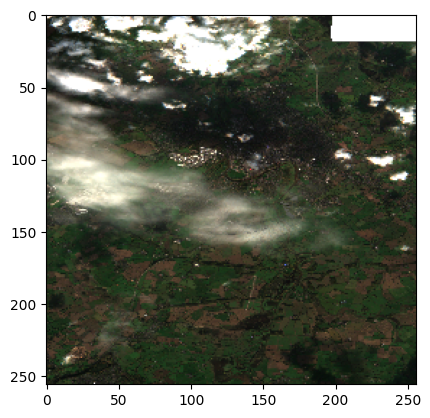

In [37]:
from PIL import Image
import io
import matplotlib.pyplot as plt

tile = wmts.gettile(
    layer="S2L1C__TRUE_COLOR",
    style="default",
    tilematrixset="WGS84",
    tilematrix="10",
    row=209,
    column=1007,
    format="image/png",
    time="2023-11-15T11:22:39Z/2023-11-15T11:22:39Z",
)

image = Image.open(io.BytesIO(tile.read()))

plt.imshow(image)

Or view a layer in Folium map. 

In [46]:

layer = wmts.contents["S2L1C__TRUE_COLOR"]
print(layer.id)
print(layer.tilematrixsetlinks)
print(layer.tilematrixsetlinks["WGS84"].tilematrixset)

S2L1C__TRUE_COLOR
{'WGS84': <TileMatrixSetLink: WGS84, tilematrixlimits={...}>, 'GoogleMapsCompatible': <TileMatrixSetLink: GoogleMapsCompatible, tilematrixlimits={...}>}
WGS84


In [52]:


m = folium.Map(location=[55, 0], zoom_start=5)

folium.WmsTileLayer(
    url="https://test.eodatahub.org.uk/vs/cache/ows?",
    layers=layer.id,
    name="test",
    overlay=True,
    control=True,
    attr="WMTS Layer",
    fmt="image/png",
    styles="default",
    tilematrixset=layer.tilematrixsetlinks["WGS84"].tilematrixset,
    TileMatrix=10,
    time=layer.dimensions["time"]["values"][0]
).add_to(m)

folium.LayerControl().add_to(m)

m